In [261]:
#from google.colab import drive

#drive.mount('/content/contentdrive')

### Les importations

In [262]:
import os
# Les librairies de manipulation de données
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
# Les fonctions de tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Input, Multiply, Dropout

### Le chemin de nos données

In [263]:
#path = "/content/contentdrive/MyDrive/Deep-learning-final/data2"
path = "data2"
real_test = "real_test"

### Les constantes

In [264]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 50
FT_EPOCHS = 20
labels = ['angry', 'happiness','fear','disgusted','surprised']
NUM_CLASSES = len(labels)

### Les fonctions utiles

In [265]:
# Afficher les analyses
def plot_training_analysis(history):

  # Récupérer les données d'entraînement et de validation
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Récupérer le nombre d'époques
  epochs = range(len(acc))

  # Afficher les courbes d'entraînement et de validation pour l'accuracy
  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  # Afficher les courbes d'entraînement et de validation pour la loss
  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  # Afficher les graphiques
  plt.show()

In [266]:
# Détection de visage et extraction de la région d'intérêt (ROI)
def detect_face_and_extract_roi(image, image_size):
    # Charger le classifieur de visages pré-entraîné
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Détecter les visages dans l'image
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # Si aucun visage n'est détecté, retourner None
    if len(faces) == 0:
        return None

    # Sélectionner le premier visage détecté
    (x, y, w, h) = faces[0]

    # Redimensionner le visage détecté à la taille spécifiée
    roi = cv2.resize(image[y:y+h, x:x+w], (image_size, image_size))

    return roi


In [267]:
# Charger les images d'un répertoire avec détection de visage et extraction de ROI
def load_data(data_path, classes, dataset='train', image_size=64):
    x = []
    y = []

    # Parcours des différents répertoires pour collecter les images
    for idx_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_path, dataset, class_name)
        for item in os.listdir(class_dir):
            img_path = os.path.join(class_dir, item)
            if os.path.isfile(img_path):
                # Ouvrir l'image
                img = Image.open(img_path)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Détection de visage et extraction de ROI
                roi = detect_face_and_extract_roi(np.asarray(img), image_size)
                if roi is not None:
                    x.append(roi)
                    y.append(idx_class)

    # Convertir les listes en tableaux NumPy
    x = np.array(x)
    y = np.array(y).reshape(-1, 1)

    return x, y


def load_data_for_real_test(data_path, image_size=64):
    x = []
    y = []

    # Parcours des différents répertoires pour collecter les images
    for class_name in os.listdir(data_path):
        class_dir = os.path.join(data_path, class_name)
        if os.path.isdir(class_dir):
            for item in os.listdir(class_dir):
                img_path = os.path.join(class_dir, item)
                if os.path.isfile(img_path):
                    # Ouvrir l'image
                    img = Image.open(img_path)
                    # Conversion de l'image en RGB
                    img = img.convert('RGB')
                    # Redimensionner l'image
                    roi = detect_face_and_extract_roi(np.asarray(img), image_size)
                    if roi is not None:
                        x.append(roi)
                        y.append(class_name)

    # Convertir les listes en tableaux NumPy
    x = np.array(x)
    y = np.array(y)

    return x, y


In [268]:
# extraire la région de la bouche
def extract_mouths_data(data_path, classes, dataset='train', image_size=64):
    x = []
    y = []

    # Parcours des différents répertoires pour collecter les images
    for idx_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_path, dataset, class_name)
        for item in os.listdir(class_dir):
            img_path = os.path.join(class_dir, item)
            if os.path.isfile(img_path):
                # Ouvrir l'image
                img = Image.open(img_path)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Extraire la région de la bouche
                mouth_region = extract_mouth_from_image(np.asarray(img), image_size)
                if mouth_region is not None:
                    x.append(mouth_region)
                    y.append(idx_class)

    # Convertir les listes en tableaux NumPy
    x = np.array(x)
    y = np.array(y).reshape(-1, 1)

    return x, y

def extract_mouth_from_image(image, image_size=64):
    # Charger le classifieur de visages pré-entraîné
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Détecter les visages dans l'image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Si au moins un visage est détecté, extraire la région de la bouche
    if len(faces) > 0:
        x, y, w, h = faces[0]  # Utiliser le premier visage détecté
        mouth_region = image[y + h//2:y + h, x:x + w]  # Extraire la région de la bouche
        # Redimensionner la région de la bouche si nécessaire
        if image_size is not None:
            mouth_region = cv2.resize(mouth_region, (image_size, image_size))
        return mouth_region
    else:
        return None


In [269]:
# Matrice de confusion
def plot_confusion_matrix(x, y, classes, model, normalize=True, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Matrice de confusion normalisée'
        else:
            title = 'Matrice de confusion non normalisée'

    # Convertir les prédictions du modèle en classes
    y_pred = np.argmax(model.predict(x), axis=1)

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y, y_pred)

    # Normalisation de la matrice de confusion si nécessaire
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    # Affichage de la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    plt.title(title)
    plt.show()
    
def plot_confusion_matrix_vgg16(x_test, y_test, model_vgg19, base_model, labels, normalize=True, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Matrice de confusion normalisée'
        else:
            title = 'Matrice de confusion non normalisée'

    # Obtenir les caractéristiques des images de test à partir du modèle VGG19
    features_test = base_model.predict(x_test)
    
    # Aplatir les caractéristiques
    features_test = features_test.reshape((features_test.shape[0], -1))
    
    # Prédiction des étiquettes sur les données de test
    y_pred = np.argmax(model_vgg19.predict(features_test), axis=1)
    
    # Création de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    
    # Normalisation de la matrice de confusion si nécessaire
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion normalisée")
    else:
        print('Matrice de confusion non normalisée')

    # Affichage de la matrice de confusion
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    plt.title(title)
    plt.show()



In [270]:
def calculate_accuracy(x_test, y_test, model):
    # Prédiction sur les données de test
    y_pred = np.argmax(model.predict(x_test), axis=1)

    # Conversion des tableaux en une dimension
    y_test = y_test.ravel()
    y_pred = y_pred.ravel()

    # Calcul de l'exactitude par classe
    global_accuracy = 0
    unique_classes = np.unique(np.concatenate([y_test, y_pred]))
    class_accuracies = {}
    for cls in unique_classes:
        cls_indices = np.where(y_test == cls)[0]
        cls_correct_predictions = np.sum(y_pred[cls_indices] == cls)
        cls_total_samples = len(cls_indices)
        cls_accuracy = cls_correct_predictions / cls_total_samples if cls_total_samples != 0 else 0
        class_accuracies[cls] = cls_accuracy
        global_accuracy += cls_accuracy
        print(f"La précision pour la classe {labels[cls]} :", cls_accuracy)

    # Précision globale du modèle
    print("La précision globale :", global_accuracy / len(labels))


def calculate_accuracy_vgg16(x_test, y_test, model_vgg19, base_model):
    # Extraction des caractéristiques des données de test en utilisant le modèle de base VGG19
    x_vgg19_test = base_model.predict(x_test)
    x_vgg19_test = np.reshape(x_vgg19_test, (x_vgg19_test.shape[0], 2*2*512))

    # Prédiction sur les données de test
    y_pred = np.argmax(model_vgg19.predict(x_vgg19_test), axis=1)

    # Conversion des tableaux en une dimension
    y_test = y_test.ravel()
    y_pred = y_pred.ravel()

    # Calcul de l'exactitude par classe
    global_accuracy = 0
    unique_classes = np.unique(np.concatenate([y_test, y_pred]))
    class_accuracies = {}
    for cls in unique_classes:
        cls_indices = np.where(y_test == cls)[0]
        cls_correct_predictions = np.sum(y_pred[cls_indices] == cls)
        cls_total_samples = len(cls_indices)
        cls_accuracy = cls_correct_predictions / cls_total_samples if cls_total_samples != 0 else 0
        class_accuracies[cls] = cls_accuracy
        global_accuracy += cls_accuracy
        print(f"La précision pour la classe {labels[cls]} :", cls_accuracy)

    # Précision globale du modèle
    print("La précision globale :", global_accuracy / len(labels))



### Chargement des données

In [271]:
x_train, y_train = load_data(path, labels, dataset='train', image_size=IMAGE_SIZE)
#print(x_train.shape, y_train.shape)

x_val, y_val = load_data(path, labels, dataset='validation', image_size=IMAGE_SIZE)
#print(x_val.shape, y_val.shape)

x_test, y_test = load_data(path, labels, dataset='test', image_size=IMAGE_SIZE)
#print(x_test.shape, y_test.shape)

x_real_test, y_real_test = load_data_for_real_test(real_test, image_size=IMAGE_SIZE)

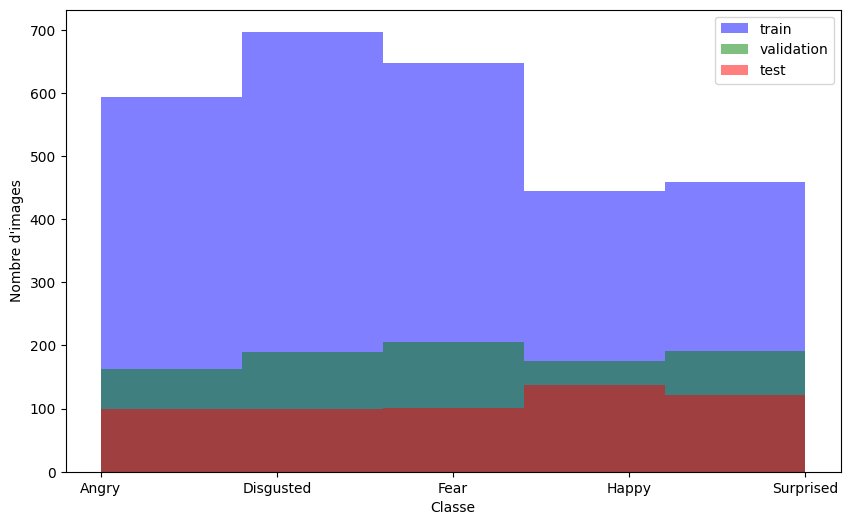

In [272]:
# Définir les étiquettes des émotions
emotion_labels = ['Angry', 'Disgusted', 'Fear', 'Happy', 'Surprised']

# Graphe pour afficher le nombre d'images par classe avec des couleurs pour différencier les ensembles d'entraînement, de validation et de test
plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=5, alpha=0.5, label='train', color='blue')
plt.hist(y_val, bins=5, alpha=0.5, label='validation', color='green')
plt.hist(y_test, bins=5, alpha=0.5, label='test', color='red')

# Ajouter les étiquettes des émotions sur l'axe x
plt.xticks(range(5), emotion_labels)

plt.xlabel('Classe')
plt.ylabel("Nombre d'images")
plt.legend()
plt.show()


In [273]:
# Données des bouches (on a essayé de faire un entrainement du modèle sur les bouches des personnes pour identifier les emotions) !!! La précision n'a pas augmenté

#x_train, y_train = extract_mouths_data(path, labels, dataset='train', image_size=IMAGE_SIZE)
#x_val, y_val = extract_mouths_data(path, labels, dataset='validation', image_size=IMAGE_SIZE)
#x_test, y_test = extract_mouths_data(path, labels, dataset='test', image_size=IMAGE_SIZE)

In [274]:
# Normalisation des données
#x_train = x_train/255
#x_val = x_val/255
#x_test = x_test/255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


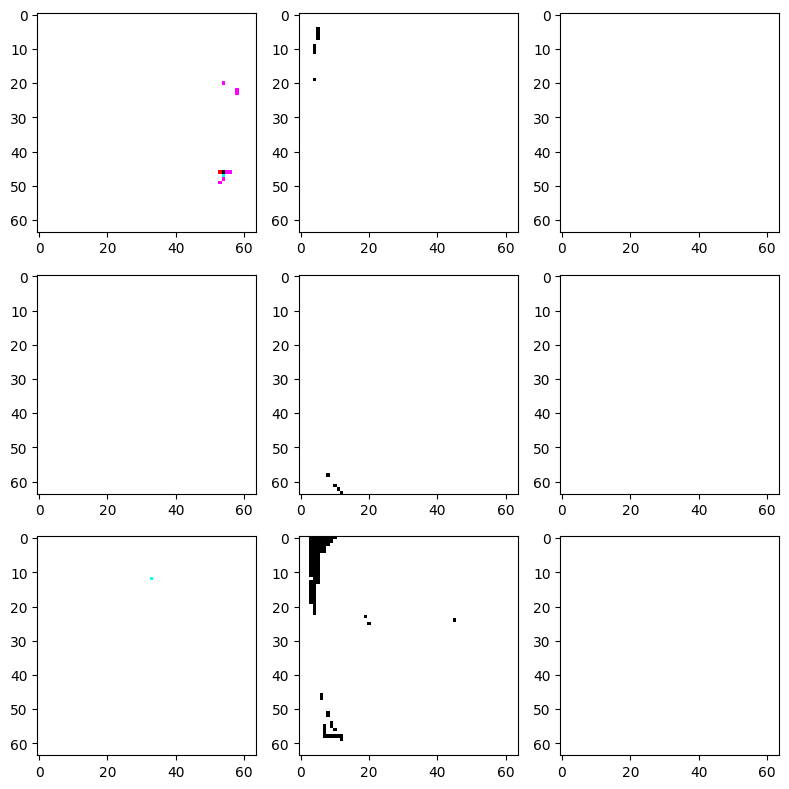

In [275]:
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
plt.figure(figsize=(8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i])
plt.tight_layout()
plt.show()

### Générer plus de données

In [276]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.05
    )

#gen_data = train_datagen.flow(x_train, y_train, BATCH_SIZE)

In [277]:
#x_gen, y_gen = next(gen_data)
#x_gen_img, y_gen_img = x_gen/255, y_gen/255
#indices = np.arange(x_gen_img.shape[0])
#np.random.shuffle(indices)
#plt.figure(figsize=(8, 8))
#for i in range(0, 9):
    #plt.subplot(3, 3, i+1)
    #plt.imshow(x_gen_img[i])
#plt.tight_layout()
#plt.show()

### Modèle simple

In [278]:
# Définition du modèle
model_simple = Sequential()

model_simple.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_simple.add(MaxPooling2D((2, 2)))

model_simple.add(Conv2D(64, (3, 3), activation='relu'))
model_simple.add(MaxPooling2D((2, 2)))

model_simple.add(Conv2D(96, (3, 3), activation='relu'))
model_simple.add(MaxPooling2D((2, 2)))

model_simple.add(Conv2D(128, (3, 3), activation='relu'))
model_simple.add(MaxPooling2D((2, 2)))

model_simple.add(Flatten())

model_simple.add(Dense(512, activation='relu'))
model_simple.add(Dense(NUM_CLASSES, activation="softmax"))  # 6 classes d'émotions différentes

C:\Users\offic\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [279]:
# Compiler le modèle
model_simple.summary()
model_simple.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=3e-4), metrics=['sparse_categorical_accuracy'])

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 12, 12, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 6, 6, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 4, 4, 128)      │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 450,725 (1.72 MB)

 Trainable params: 450,725 (1.72 MB)

 Non-trainable params: 0 (0.00 B)

##### Entrainer le modèle

In [280]:
# Entraînement du modèle
history_simple = model_simple.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS)

Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 9.1717 - sparse_categorical_accuracy: 0.2210 - val_loss: 1.6558 - val_sparse_categorical_accuracy: 0.2760
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.5656 - sparse_categorical_accuracy: 0.3061 - val_loss: 1.7133 - val_sparse_categorical_accuracy: 0.2403
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.4779 - sparse_categorical_accuracy: 0.3532 - val_loss: 1.5620 - val_sparse_categorical_accuracy: 0.3149
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.3789 - sparse_categorical_accuracy: 0.4187 - val_loss: 1.4758 - val_sparse_categorical_accuracy: 0.3387
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.2657 - sparse_categorical_accuracy: 0.4765 - val_loss: 1.6066 - val_sparse_categorical_accuracy: 0.3550
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.2091 - sparse_categorical_accuracy: 0.5162 - val_loss: 1.4810 - val_sparse_categorical_accuracy: 0.3755
Epoch 7/50

##### Analyser les résultats

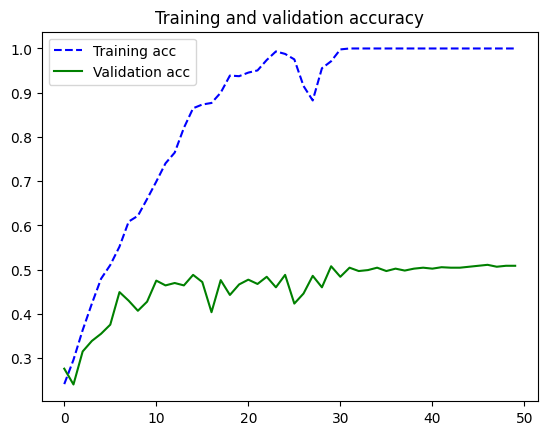

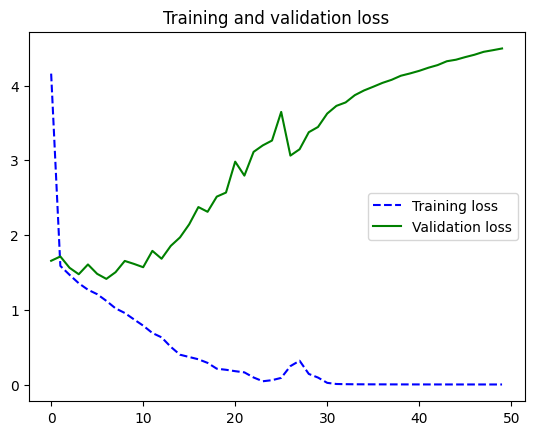

In [281]:
# Affichage les courbes
plot_training_analysis(history_simple)

##### Matrice de confusion

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Matrice de confusion normalisée


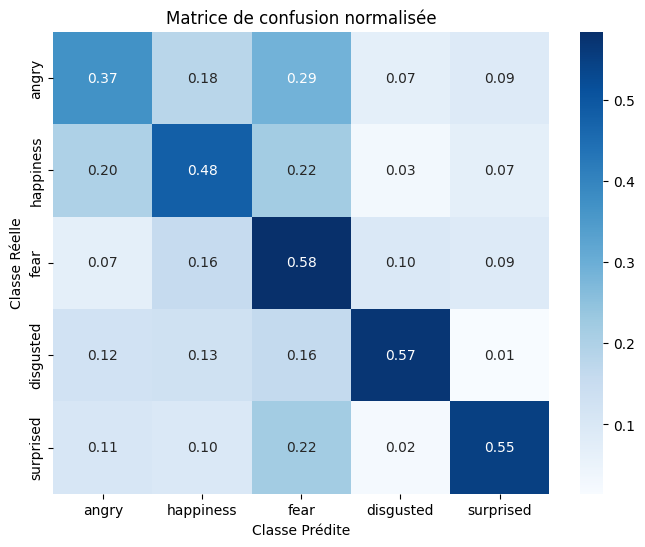

In [282]:
# Matrice de confusion
plot_confusion_matrix(x_test, y_test, labels, model_simple)

##### Précision globale et par classe (modèle simple)

In [283]:
calculate_accuracy(x_test, y_test, model_simple)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


TypeError: list indices must be integers or slices, not numpy.float64

##### Prediction réelle

In [ ]:
# Prédire les émotions sur les images du real test afficher la photo, l'emotion prédite et l'emotion réelle, calculer la précision globale et la précision par classe
y_real_test_pred = np.argmax(model_simple.predict(x_real_test), axis=1)
accuracy_global = 0
for i in range(len(y_real_test)):
    #plt.imshow(x_real_test[i])
    pred = labels[y_real_test_pred[i]]
    real = y_real_test[i]
    #plt.title(f"Emotion prédite: {pred}, Emotion réelle: {real}")
    #plt.show()
    if pred == real:
        accuracy_global += 1
        
print(f"Précision globale: {accuracy_global/len(y_real_test)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Précision globale: 0.2


### Modèle VGG16

In [ ]:
base_model = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(64, 64, 3))


In [ ]:
# Le modèle simple
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

##### Entrainer le modèle

In [ ]:
# Chargement du modèle VGG16 et de ses caractéristiques
train_features = base_model.predict(x_train)
train_features = np.reshape(train_features,(train_features.shape[0],2*2*512))

val_features = base_model.predict(x_val)
val_features = np.reshape(val_features,(val_features.shape[0],2*2*512))

# Entraînement du modèle
#history_vgg19 = model_vgg19.fit(x_vgg19_train, y_train, validation_data=(x_vgg19_val, y_val), epochs=EPOCHS)

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=2*2*512))
model.add(Dropout(0.5)) # On utilise du DropOut sur cette couche dense car elle comporte un grand nombre
                               # de paramètres et risque d'être très sujette au sur-apprentissage.
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_features, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(val_features, y_val))

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
Epoch 1/50


C:\Users\offic\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.1322 - sparse_categorical_accuracy: 0.2813 - val_loss: 6.5153 - val_sparse_categorical_accuracy: 0.3548
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4341 - sparse_categorical_accuracy: 0.4056 - val_loss: 5.4702 - val_sparse_categorical_accuracy: 0.3945
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9435 - sparse_categorical_accuracy: 0.4774 - val_loss: 4.2172 - val_sparse_categorical_accuracy: 0.3672
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5380 - sparse_categorical_accuracy: 0.5439 - val_loss: 3.6320 - val_sparse_categorical_accuracy: 0.3797
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7099 - sparse_categorical_accuracy: 0.5900 - val_loss: 3.2950 - val_sparse_categorical_accuracy: 0.4020
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3044 - sparse_categorical_accuracy: 0.6204 - val_loss: 3.2002 - val_sparse_categorical_accuracy: 0.3970
Epoch 7/50
37/37 ━━━━━━━━━

##### Affichage des résultats

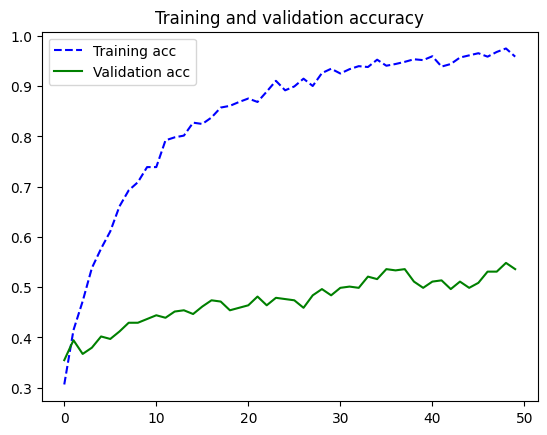

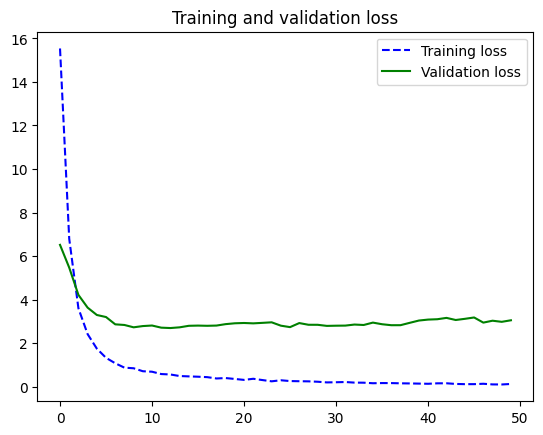

In [ ]:
# Affichage les courbes
plot_training_analysis(history)

##### Matrice de confusion

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Matrice de confusion normalisée


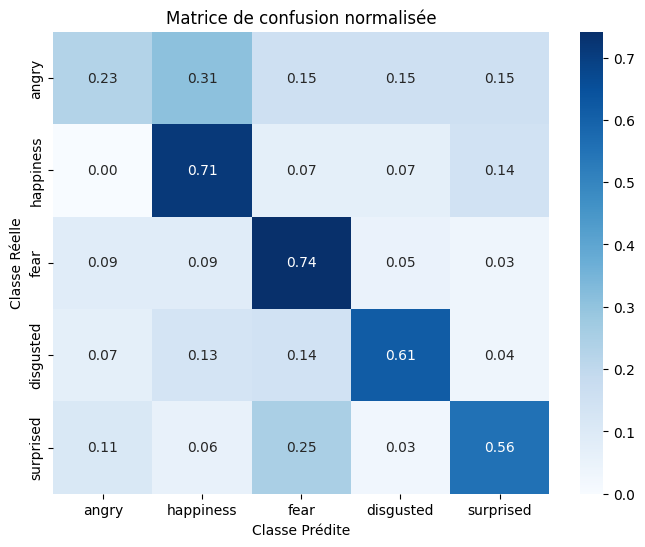

In [ ]:
# Matrice de confusion
plot_confusion_matrix_vgg16(x_test, y_test, model, base_model, labels)

##### Précision globale et par classe (sans fine tuning)

In [ ]:
calculate_accuracy_vgg16(x_test, y_test, model, base_model)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
La précision pour la classe angry : 0.23076923076923078
La précision pour la classe happiness : 0.7142857142857143
La précision pour la classe fear : 0.7413793103448276
La précision pour la classe disgusted : 0.6144578313253012
La précision pour la classe surprised : 0.5555555555555556
La précision globale : 0.5712895284561259


### Fine Tuning (VGG16)

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
base_model.trainable = False
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-5),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(y_train, y_val),
    epochs=FT_EPOCHS,
)

Epoch 1/20


C:\Users\offic\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 12.6384 - sparse_categorical_accuracy: 0.2094

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1165
'y' sizes: 403


In [ ]:
plot_training_analysis(history)

In [ ]:
# Matrice de confusion
plot_confusion_matrix(x_test, y_test, labels, model)

##### Affichage des résultats

In [ ]:
plot_training_analysis(history)